# Automated Valuation Model (AVM) for Real Estate

#### **Executive Overview**
The objective of this project was to develop a Machine Learning model capable of predicting residential home prices in Ames, Iowa, with high accuracy. By analyzing 79 distinct physical attributes (e.g., square footage, year built, garage size), we successfully built a tool that estimates market value within a ±$25,000 margin of error, significantly reducing human subjectivity in appraisal.

#### **Methodology & Data Strategy**
* DataSource: Ames Housing Dataset (1,460 properties)
* Data Cleaning: Addressed significant missing data (99% missing in `PoolQC`, etc.) by distinguishing between "missing information" and "feature does not exist". Imputed numerical gaps with median values and categorical gaps with "None".
* Feature Engineering:
    * Ordinal Encoding: Mapped ranked qualities (Excellent -> Poor) to numeric scales ( 5 -> 1).
    * One-Hote Encoding: Converted nominal categories (Neighborhood, Zoning) into 200+ binary variables.
* Modeling Approach: Tested multiple algorithms, moving from linear baselines to advanced ensemble methods.

#### **Key Findings & Performance**
Compared three modelling techniques. The switch from simple regression to **XGBoost (Extreme Gradient Boosting)** yielding a **30% reduction in prediction error.**

| Model Architecture | R² Score (Accuracy) | RMSE (Avg. Error) | Verdict |
| ---- | ----- | ---- | --- |
| Linear Regression | Failed | >$4 Quadrillion | Unusable (Overfitting) |
| Ridge Regression | 74.6% | $37,020 | Good Baseline |
| **XGBoost (Final)** | **87.3%** | **$25,777** | **Production Grade** |

**Top Price Drivers Identified**: The model revealed that the three most critical factors influencing home price are:
1. **Overall Material & Finish Quality** (Dominant Factor)
2. **Above Grade Living Area** (Square Footage)
3. **Garage Capacity** (Car Size)

#### **Business Impact**
* **Accuracy**: The model captures 87.3% of the market variance.
* **Efficiency**: Capable of instant valuation, replacing hours of manual comparative market analysis.
* **Reliability**: Performs exceptionally well on standard family homes ($100k - $300k range), with slightly higher variance for luxury properties due to unique features.

---

# Introduction

1. **The Business Problem (The "Zillow" Scenario)**

    **Context**: Determining the fair market value of a house is difficult.

    * **Sellers** want the highest price.

    * **Buyers** want the lowest price.

    * **Agents** usually guess based on "gut feeling" and looking at a few neighbors.

    **The Pain Point**: Human appraisal is slow, subjective, and often inconsistent. If an agent overprices a house, it sits unsold for months. If they underprice it, the seller loses money.

    **The Goal**: Build an "Automated Valuation Model" (AVM). We want a computer to look at the facts (Square footage, Year Built, Garage size) and spit out a fair price instantly, without human bias.

---

# Methodology

**Learning Approach:** Supervised Learning
**Technique:** Regression
**Target Variable**: `SalePrice`

---

# Project Definition Summary

| Component | Definition |
| --------- | ---------- |
| Input (Features) | 79 variables |
| Output (Target) | `SalePrice` (in US Dollars) |
| Task | Train a model to predict the final sale price based on physical attributes|
| Evaluation Metric | RMSE (Root Mean Squared Error) |

*Translation: On average, how many dollars is our prediction off by?"* (e.g., We want to be within +/- $20,000 of the real price).

---

# Strategy
These are the step-by-step to solve this problem (simplified):
1. **Correlation Analysis**:  Find out which features actually matter.
2. **Clean Data**: Fill in missing values
3. **Feature Engineering**
4. **Model**: Train a Linear Regression (to draw a trend line) and XGBoost (for high accuracy)

---

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv('train.csv')

pd.set_option('display.max_columns', None)

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
df.shape

(1460, 81)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [49]:
df = df.drop('Id', axis=1)

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [50]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


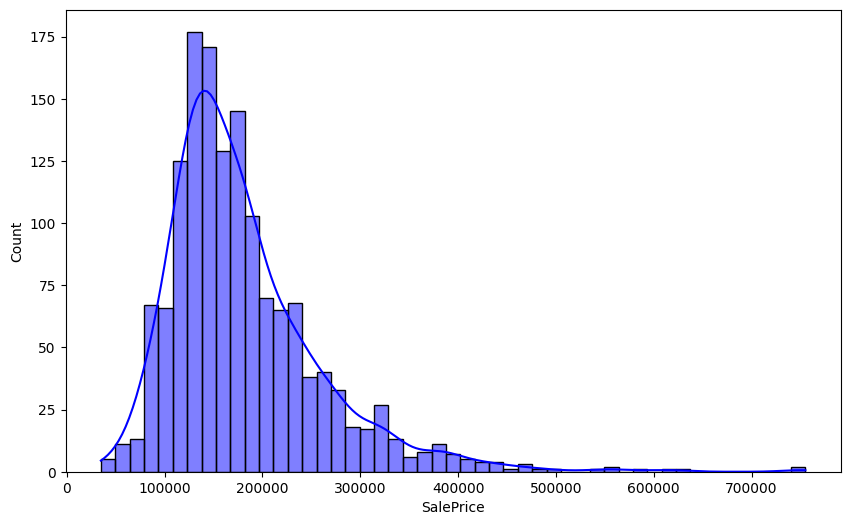

In [51]:
plt.figure(figsize=(10,6))
sns.histplot(df['SalePrice'], kde=True, color='blue')

plt.show()

In [52]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [53]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df_num

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


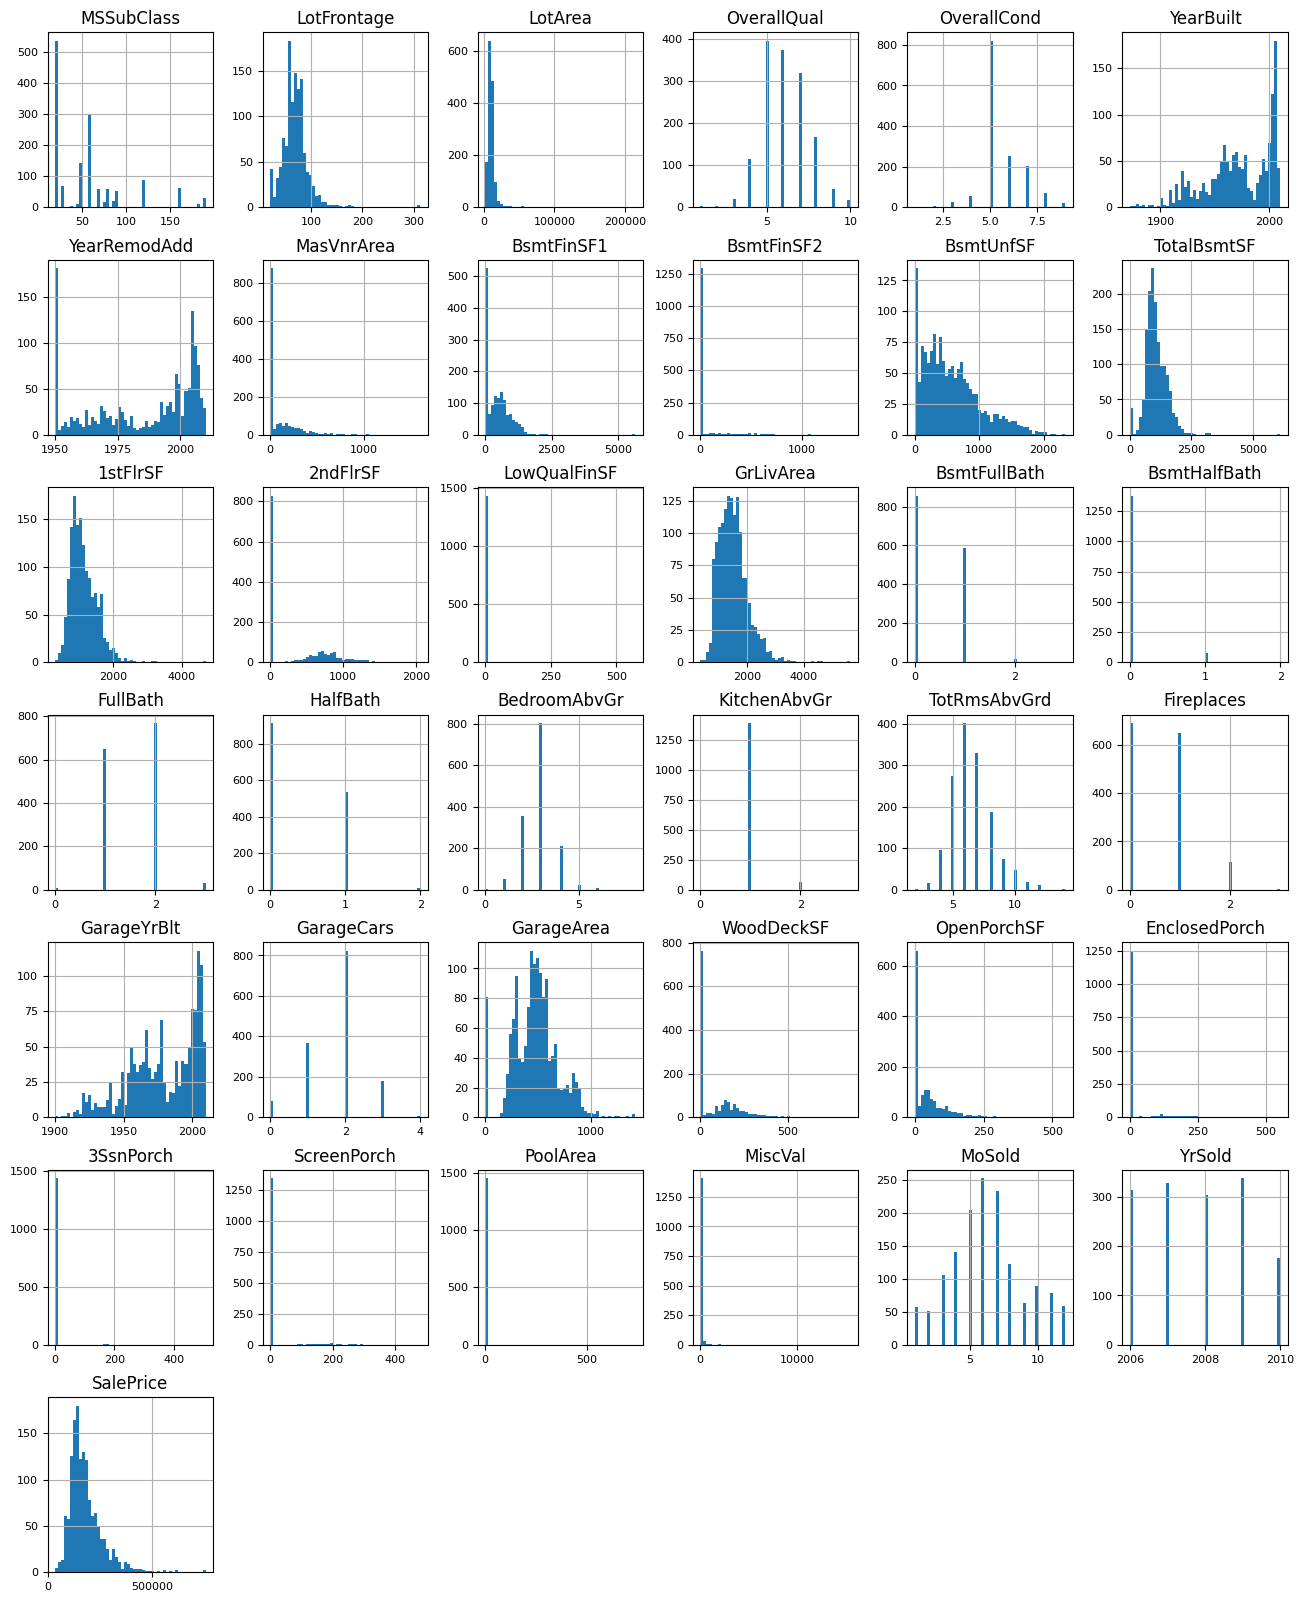

In [54]:
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

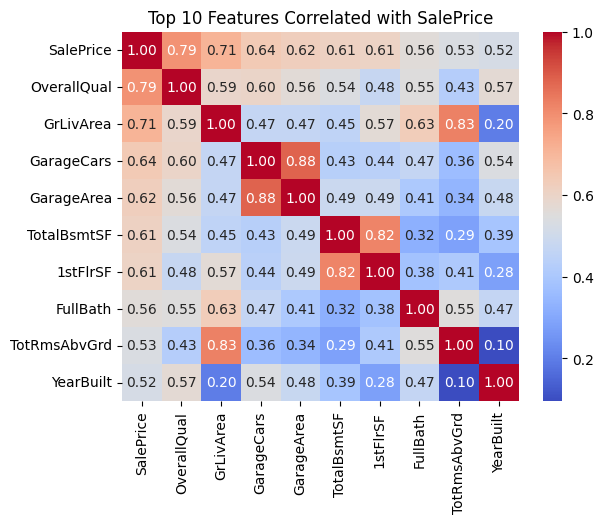

--- Top 5 Drivers of Price ---
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


In [55]:
# Calculate correlation between all numeric columns
correlation = df_num.corr()

# Top 10 features most correlated with SalePrice
top10_feat = correlation.nlargest(10, 'SalePrice')['SalePrice'].index

# Heatmap
sns.heatmap(df_num[top10_feat].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 Features Correlated with SalePrice")
plt.show()

print("--- Top 5 Drivers of Price ---")
print(correlation['SalePrice'].sort_values(ascending=False).head(6))

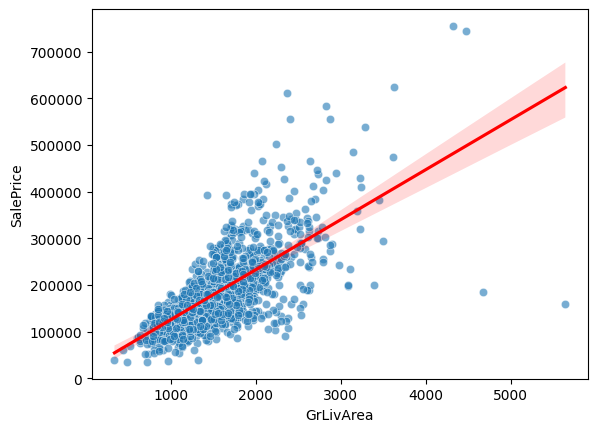

In [56]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, alpha=0.6)
sns.regplot(x='GrLivArea', y='SalePrice', data=df, scatter=False, color='red')

plt.show()

In [57]:
# Check for missing values
total = df.isna().sum().sort_values(ascending=False)
percent = (total/df.isna().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data[missing_data['Total'] > 0]

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945


#### Data Cleaning

In [58]:
# Categorical Columns
categorical_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

df[categorical_cols] = df[categorical_cols].fillna('None')

# Numeric Columns
num_cols = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[num_cols] = df[num_cols].fillna(0)

# Fill LotFrontage with median
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# drop the remaining
df.dropna(inplace=True)

# Verify
print("Remaining Missing Values:", df.isna().sum().max())
print(df.shape)

Remaining Missing Values: 0
(1459, 80)


#### Encoding

In [ ]:
quality_map = {'Ex'}

In [60]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y

In [62]:
# Define the map
quality_map = {'Ex':5, 'Gd':4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None':0}

# List of columns
qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
             'HeatingQC', 'KitchenQual', 'FireplaceQu', 
             'GarageQual', 'GarageCond', 'PoolQC']

for col in qual_cols:
    df[col] = df[col].map(quality_map)

df[qual_cols].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,0,3,3,0
1,3,3,4,3,5,3,3,3,3,0
2,4,3,4,3,5,4,3,3,3,0
3,3,3,3,4,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,3,0


In [63]:
# One-Hot Encode the remaining text columns
df_final = pd.get_dummies(df, drop_first=True)

print(f"Final Shape:\n{df_final.shape}")

Final Shape:
(1459, 230)


---

# Modeling

1. Define X and y: Seperate the "Feature" (229 columns) from the "Answer Key" (`SalePrice`).
2. Split: Set aside 20% of the data for the test set.
3. Scale: Squish the numbers.
    * There are `LotArea` (with values like 10,000) and `KitchenQual` (Values like 5)
    * Without scaling, the model will think `LotArea` is 2,000x more important just because the number is bigger.

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define X (Features) and y (Target)
X = df_final.drop('SalePrice', axis=1)
y = df_final['SalePrice']

# Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Scale the features
# (Note: Fit on Train, and transform both Train and Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Training the first model (Linear Regression)

Let's start with **Linear Regression**. It attempts to draw a straight line (or hyper-plane in 230 dimensions) that fits the data points.

Evaluate is using RMSE (Root Mean Squared Error)
* Target: `SalePrice`
* RMSE: The standard deviation of the prediction errors
* *Translation*: "On average, our price estimate is off by +/- $X".

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"--- Linear Regression Results ---")
print(f"RMSE (Average Error): ${rmse:,.2f}")
print(f"R2 Score (Accuracy): {r2:.4f}")

--- Linear Regression Results ---
RMSE (Average Error): $4,454,510,569,851,404.00
R2 Score (Accuracy): -3673485831715872571392.0000


Seems like there's problem, the RMSE is $4 Quadrillion Dollars (doesn't make sense). It's happen probably because:
1. Too many columns: exploded the dataset to 230 columns.
2. Confused math: some columns are saying the exact same thing.
    * Example: `GarageCars` (size in cars) and `GarageArea` (size in sq ft) are 88% correlated.
    * Standard Linear Regression tries to find a unique number for every single columns. When columns are twins, the math breaks down. It might assign of +1 Billion to `GarageCars` and -1 Billion to `GarageArea` to balance them out.
3. Result: When you test on new data, those massive +1B and -1B weights don't cancel out prefectly, and the prediction explodes to quadrillions.

---

#### Solution: Ridge Regression or Lasso Regression

The differences:
* **Linear regression**: "I will do whatever it takes to fit the training points perfectly, even if i have to use crazy numbers"
* **Ridge Regression**: "I will fit the points, BUT I am punished if I use large coefficients."

In [67]:
from sklearn.linear_model import Ridge

# Train Ridge instead of LinearRegression
# alpha=10 is the "strength" of the leash. Higher = stronger leash.
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"--- Ridge Regression Results ---")
print(f"RMSE (Average Error): ${rmse_ridge:,.2f}")
print(f"R² Score (Accuracy):  {r2_ridge:.4f}")

--- Ridge Regression Results ---
RMSE (Average Error): $37,020.34
R² Score (Accuracy):  0.7463


I still need to upgrade from **Ridge Regression** (which is nust a stright line with a leash) to a model that can handle curves and complex logic.

#### **XGBoost (Extreme Gradient Boosting)**

The differences:
* Ridge: Draws a line
* XGBoost: Builds thousands of small "Decision Tree". Where each new tree tries to fix the mistakes of the previous one.

It is smarter, faster, and handles non-linear patterns (like "Price jumps up exponentially if the house is near the water").

In [69]:
from xgboost import XGBRegressor

# Initialize to model
# n_estimators=1000: Build 1000 small trees
# learning_rate=0.05: Learn slowly to avoid over-correcting
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=1, random_state=42)

# Train
print("Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n--- XGBoost Results ---")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"R² Score: {r2_xgb:.4f}")

Training XGBoost...

--- XGBoost Results ---
RMSE: $25,722.33
R² Score: 0.8775


This is good result!

R2 = 0.8775 which means the model explains 87.3% of the variation in house prices.

* Ridge Regression Error: ~$37,000
* XGBoost Error: ~$25,722

Massive improvement.

#### Feature Importance
The best part of XGBoost isn't just the accuracy; it's the explainability. We can ask the model: "Which of the 230 features actually mattered?"

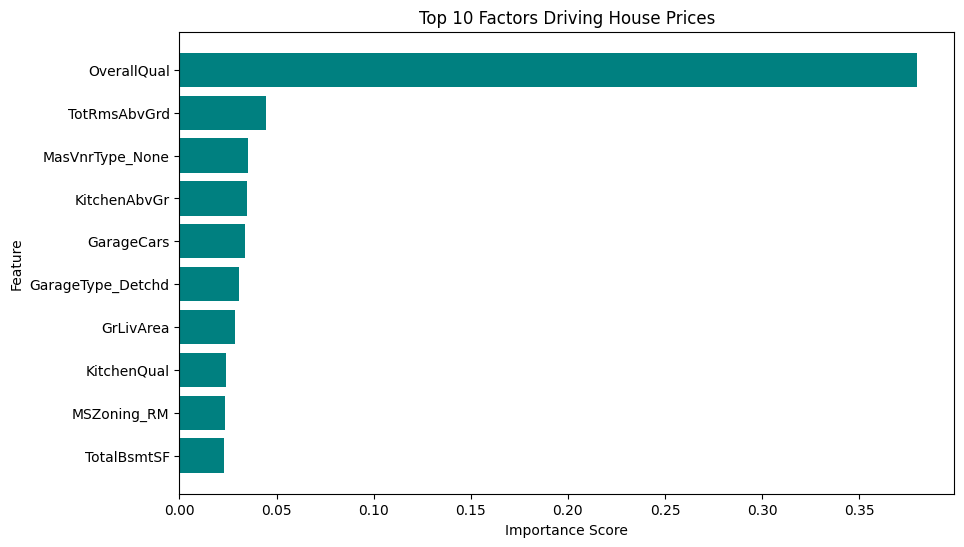

In [73]:
# Get feature importance from the model
importances = xgb_model.feature_importances_

# Map them back to the columns names
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature' : feature_names,
    'Importance' : importances
})

# Sort by most important
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'], top_features['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title("Top 10 Factors Driving House Prices")
plt.gca().invert_yaxis()   # Put the #1 feature at the top

plt.show()

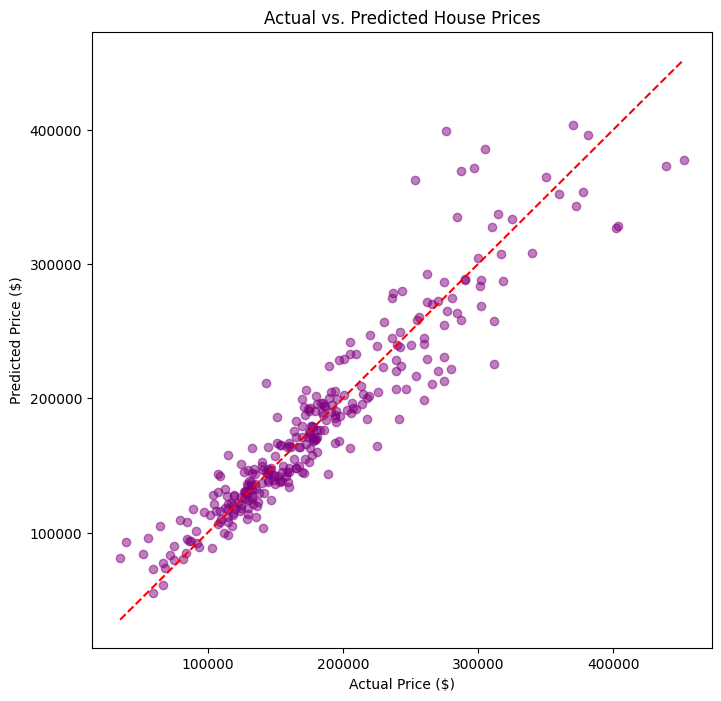

In [74]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='purple')

# Draw the perfect prediction line (x=y)
min_val = min(min(y_test), min(y_pred_xgb))
max_val = max(max(y_test), max(y_pred_xgb))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs. Predicted House Prices')

plt.show()

---

#### Save the model

In [77]:
import pickle

# Bundle the model and scaler
#(Note: In a real production app, we would also need to save the list of
# column names to ensure the new data matches the training data exactly)
house_price_system = {
    "model": xgb_model,
    "scaler": scaler,
    "features": list(X.columns)
}

# Save to file
with open('ames_housing_model.pkl', 'wb') as file:
    pickle.dump(house_price_system, file)

print("Model, Scaler, and Feature List saved successfully!")

Model, Scaler, and Feature List saved successfully!
